# Setup & Data loading

In [3]:
# imports
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import backend as K

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)


In [4]:
df = pd.read_csv("hate_speech_dataset.tsv")
df["cleaned_post"] = df["cleaned_post"].astype(str)

print(df["class"].value_counts())
print(df["bi_class"].value_counts())
print(df["mul_class"].value_counts())

df.drop(df[df["class"] == "explicit_hate"].index, inplace=True)
df["binary"] = (df["class"] == "implicit_hate").astype(int)
print(df["binary"].value_counts())


class
not_hate         13270
implicit_hate     7094
explicit_hate     1086
Name: count, dtype: int64
bi_class
0    13270
1     8180
Name: count, dtype: int64
mul_class
0    13270
1     7094
2     1086
Name: count, dtype: int64
binary
0    13270
1     7094
Name: count, dtype: int64


# Train/Test split

In [5]:
X = df["cleaned_post"].values
y = df["binary"].values.astype("int32")

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.15,
    random_state=RANDOM_SEED,
    stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.176,
    random_state=42,
    stratify=y_train
)

print("Train size:", len(X_train))
print("Val size:", len(X_val))
print("Test size:", len(X_test))

Train size: 14262
Val size: 3047
Test size: 3055


In [6]:
train_df = pd.DataFrame({
    "text": X_train,
    "label": y_train
})

train_min = train_df[train_df["label"] == 1]   # implicit
train_maj = train_df[train_df["label"] == 0]   # not-hate

n_min = len(train_min)
print("Train minority (implicit) size:", n_min)
print("Train majority (not_hate) size:", len(train_maj))

train_maj_down = train_maj.sample(n=n_min, random_state=42)

train_bal = pd.concat([train_min, train_maj_down]).sample(frac=1, random_state=42)

X_train_bal = train_bal["text"].values
y_train_bal = train_bal["label"].values

print("\nBalanced train label counts (1:1):")
print(pd.Series(y_train_bal).value_counts())


Train minority (implicit) size: 4969
Train majority (not_hate) size: 9293

Balanced train label counts (1:1):
0    4969
1    4969
Name: count, dtype: int64


# Baseline Model: Naive Bayers + TF-IDF


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb_1 = nb_model.predict(X_test_tfidf)


Naive Bayes (Implicit vs Not Hate) Report:
              precision    recall  f1-score   support

           0     0.7045    0.9578    0.8118      1991
           1     0.7586    0.2481    0.3739      1064

    accuracy                         0.7106      3055
   macro avg     0.7315    0.6030    0.5929      3055
weighted avg     0.7233    0.7106    0.6593      3055



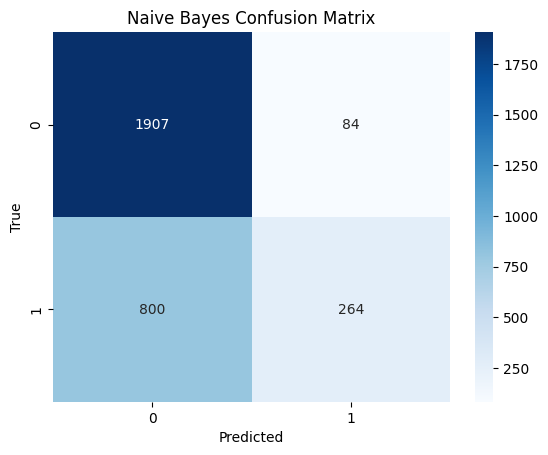

In [8]:
print("Naive Bayes (Implicit vs Not Hate) Report:")
print(classification_report(y_test, y_pred_nb_1, digits=4))

cm_nb = confusion_matrix(y_test, y_pred_nb_1)
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Blues")
plt.title("Naive Bayes Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [9]:
class_counts = np.bincount(y_train)
total = len(y_train)

# inverse frequency weighting
w0 = total / class_counts[0]
w1 = total / class_counts[1]

print("class 0 weight:", w0)
print("class 1 weight:", w1)

sample_weights = np.array([w0 if y==0 else w1 for y in y_train])
tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train, sample_weight=sample_weights)

y_pred_nb_2 = nb_model.predict(X_test_tfidf)


class 0 weight: 1.5347035402991498
class 1 weight: 2.870195210303884


Naive Bayes (Implicit vs Not Hate) Report(with class weight):
              precision    recall  f1-score   support

           0     0.8015    0.6856    0.7390      1991
           1     0.5370    0.6823    0.6010      1064

    accuracy                         0.6845      3055
   macro avg     0.6693    0.6840    0.6700      3055
weighted avg     0.7094    0.6845    0.6910      3055



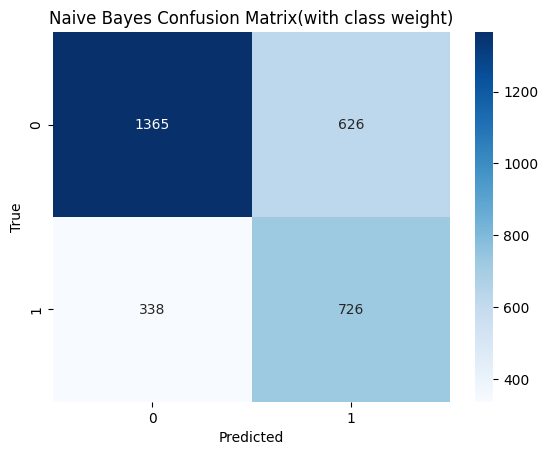

In [44]:
print("Naive Bayes (Implicit vs Not Hate) Report(with class weight):")
print(classification_report(y_test, y_pred_nb_2, digits=4))

cm_nb = confusion_matrix(y_test, y_pred_nb_2)
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Blues")
plt.title("Naive Bayes Confusion Matrix(with class weight)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [11]:
X_train_bal_tfidf = tfidf.fit_transform(X_train_bal)
X_test_bal_tfidf = tfidf.transform(X_test)

nb_model = MultinomialNB()
nb_model.fit(X_train_bal_tfidf, y_train_bal)
y_pred_nb_3 = nb_model.predict(X_test_bal_tfidf)

Naive Bayes (Implicit vs Not Hate) Report(downsampling):
              precision    recall  f1-score   support

           0     0.8109    0.6524    0.7231      1991
           1     0.5237    0.7152    0.6047      1064

    accuracy                         0.6743      3055
   macro avg     0.6673    0.6838    0.6639      3055
weighted avg     0.7109    0.6743    0.6818      3055



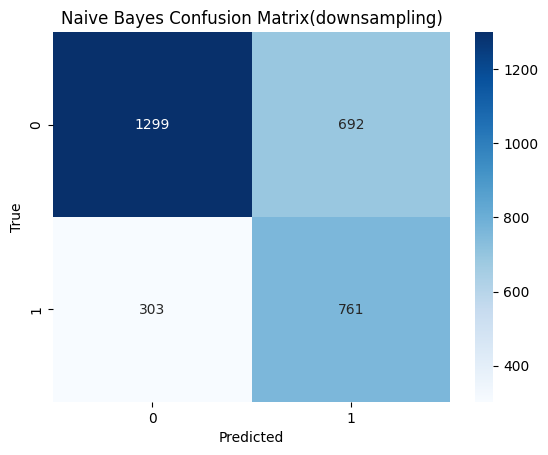

In [12]:
print("Naive Bayes (Implicit vs Not Hate) Report(downsampling):")
print(classification_report(y_test, y_pred_nb_3, digits=4))

cm_nb = confusion_matrix(y_test, y_pred_nb_3)
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Blues")
plt.title("Naive Bayes Confusion Matrix(downsampling)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

The Naive Bayes baseline performs well at identifying the majority “other” class, achieving a very high recall of 0.95. However, its performance on implicit hate — the minority class — is extremely weak. Although precision for class 1 is moderate (0.75), recall drops to only 0.26, meaning the model misses more than 80% of implicit hate examples. This indicates that Naive Bayes relies heavily on surface-level lexical cues and cannot capture the subtle, context-dependent patterns that characterize implicit hate. As a result, the model is strongly biased toward predicting the majority class, leading to poor macro-F1 and ineffective minority-class detection.

**Although downsampling improves the recall of the implicit hate class, it comes at the cost of a substantial drop in overall accuracy (from 0.71 to 0.66).**

# Model 2: RNN - LSTM

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_WORDS = 20000
MAX_LEN = 50

tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq   = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_val_pad   = pad_sequences(X_val_seq, maxlen=MAX_LEN)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN)

## Model Building

In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
from tensorflow.keras.metrics import Precision, Recall, AUC

# class weight(for imbalanced data)
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i: w for i, w in enumerate(class_weights)}




In [15]:
EMBED_DIM = 100
LSTM_UNITS = 64

inputs = Input(shape=(MAX_LEN,))
x = Embedding(input_dim=MAX_WORDS, output_dim=EMBED_DIM)(inputs)
x = Bidirectional(LSTM(LSTM_UNITS))(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation="sigmoid")(x)

bilstm_model = Model(inputs, outputs)
bilstm_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        Precision(name="precision"),
        Recall(name="recall"),
        AUC(name="auc")
    ]
)

es = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)


### Train without class_weight

In [16]:
# train without class weight
history_rnn_1 = bilstm_model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=10,
    batch_size=64,
    callbacks=[es],
    verbose=1
)
y_pred_1 = bilstm_model.predict(X_test_pad)
y_pred_1 = (y_pred_1 >= 0.5).astype("int32").ravel()


Epoch 1/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.6574 - auc: 0.6121 - loss: 0.6235 - precision: 0.4719 - recall: 0.0995 - val_accuracy: 0.7191 - val_auc: 0.7552 - val_loss: 0.5506 - val_precision: 0.6570 - val_recall: 0.4043
Epoch 2/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7855 - auc: 0.8526 - loss: 0.4510 - precision: 0.7305 - recall: 0.6070 - val_accuracy: 0.7230 - val_auc: 0.7389 - val_loss: 0.6067 - val_precision: 0.6396 - val_recall: 0.4684
Epoch 3/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8585 - auc: 0.9235 - loss: 0.3332 - precision: 0.8241 - recall: 0.7544 - val_accuracy: 0.7178 - val_auc: 0.7375 - val_loss: 0.7032 - val_precision: 0.6414 - val_recall: 0.4298
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


### Train with class_weight

In [17]:
history_rnn_2 = bilstm_model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=10,
    batch_size=64,
    class_weight=class_weights,
    callbacks=[es],
    verbose=1
)
y_pred_2 = bilstm_model.predict(X_test_pad)
y_pred_2 = (y_pred_2 >= 0.5).astype("int32").ravel()

Epoch 1/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7746 - auc: 0.8515 - loss: 0.4819 - precision: 0.6546 - recall: 0.7479 - val_accuracy: 0.7027 - val_auc: 0.7461 - val_loss: 0.6326 - val_precision: 0.5696 - val_recall: 0.5975
Epoch 2/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8380 - auc: 0.9191 - loss: 0.3589 - precision: 0.7291 - recall: 0.8509 - val_accuracy: 0.7164 - val_auc: 0.7293 - val_loss: 0.7996 - val_precision: 0.6139 - val_recall: 0.5005
Epoch 3/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8845 - auc: 0.9565 - loss: 0.2652 - precision: 0.7962 - recall: 0.8982 - val_accuracy: 0.7050 - val_auc: 0.7142 - val_loss: 0.9623 - val_precision: 0.5896 - val_recall: 0.5024
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


### Downsampling

In [18]:
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(X_train_bal)

X_train_bal_seq = tokenizer.texts_to_sequences(X_train_bal)
X_test_bal_seq = tokenizer.texts_to_sequences(X_test)

X_train_bal_pad = pad_sequences(X_train_bal_seq, maxlen=MAX_LEN)
X_test_bal_pad = pad_sequences(X_test_bal_seq, maxlen=MAX_LEN)


In [19]:
inputs = Input(shape=(MAX_LEN,))
x = Embedding(input_dim=MAX_WORDS, output_dim=EMBED_DIM)(inputs)
x = Bidirectional(LSTM(LSTM_UNITS))(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation="sigmoid")(x)

bilstm_model = Model(inputs, outputs)
bilstm_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        Precision(name="precision"),
        Recall(name="recall"),
        AUC(name="auc")
    ]
)

es = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# train without class weight
history_rnn_3 = bilstm_model.fit(
    X_train_bal_pad, y_train_bal,
    validation_data=(X_val_pad, y_val),
    epochs=10,
    batch_size=64,
    callbacks=[es],
    verbose=1
)
y_pred_3 = bilstm_model.predict(X_test_bal_pad)
y_pred_3 = (y_pred_3 >= 0.5).astype("int32").ravel()


Epoch 1/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.5533 - auc: 0.5769 - loss: 0.6784 - precision: 0.5567 - recall: 0.5334 - val_accuracy: 0.5537 - val_auc: 0.5251 - val_loss: 0.7403 - val_precision: 0.3789 - val_recall: 0.4411
Epoch 2/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7590 - auc: 0.8389 - loss: 0.4985 - precision: 0.7631 - recall: 0.7464 - val_accuracy: 0.5199 - val_auc: 0.5160 - val_loss: 0.8895 - val_precision: 0.3546 - val_recall: 0.4618
Epoch 3/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8494 - auc: 0.9253 - loss: 0.3488 - precision: 0.8437 - recall: 0.8557 - val_accuracy: 0.5576 - val_auc: 0.5259 - val_loss: 0.8337 - val_precision: 0.3817 - val_recall: 0.4364
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


## Evaluation

### Training curve

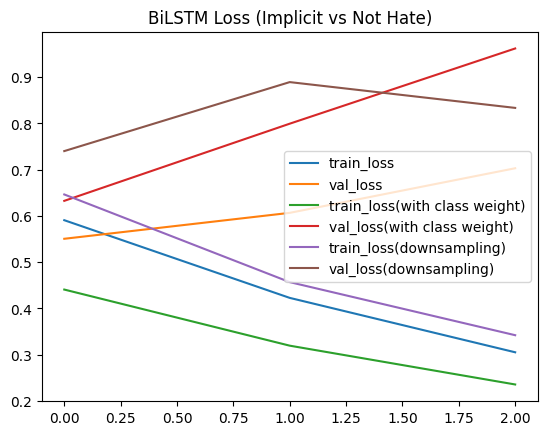

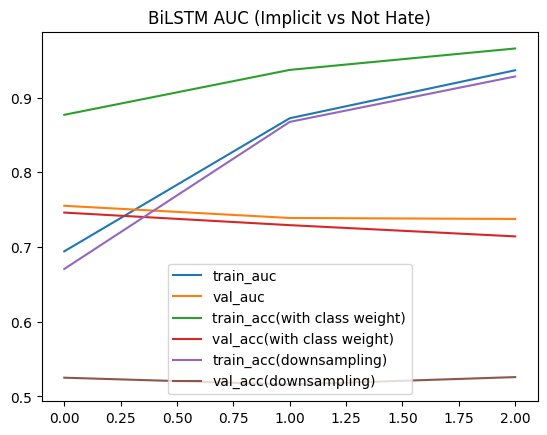

In [20]:
plt.plot(history_rnn_1.history['loss'], label='train_loss')
plt.plot(history_rnn_1.history['val_loss'], label='val_loss')
plt.plot(history_rnn_2.history['loss'], label='train_loss(with class weight)')
plt.plot(history_rnn_2.history['val_loss'], label='val_loss(with class weight)')
plt.plot(history_rnn_3.history['loss'], label='train_loss(downsampling)')
plt.plot(history_rnn_3.history['val_loss'], label='val_loss(downsampling)')
plt.legend()
plt.title("BiLSTM Loss (Implicit vs Not Hate)")
plt.show()

plt.plot(history_rnn_1.history["auc"], label="train_auc")
plt.plot(history_rnn_1.history["val_auc"], label="val_auc")
plt.plot(history_rnn_2.history['auc'], label='train_acc(with class weight)')
plt.plot(history_rnn_2.history['val_auc'], label='val_acc(with class weight)')
plt.plot(history_rnn_3.history['auc'], label='train_acc(downsampling)')
plt.plot(history_rnn_3.history['val_auc'], label='val_acc(downsampling)')
plt.legend()
plt.title("BiLSTM AUC (Implicit vs Not Hate)")
plt.show()


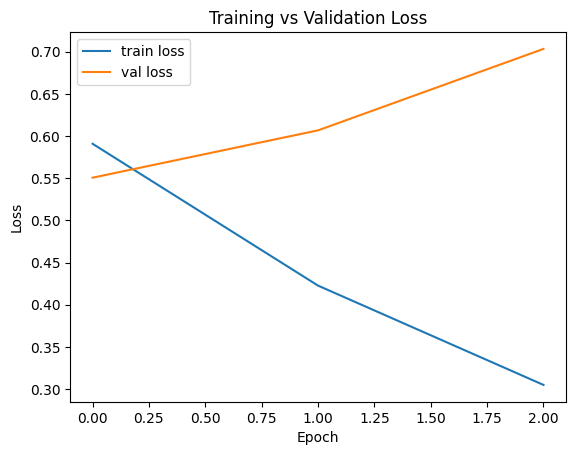

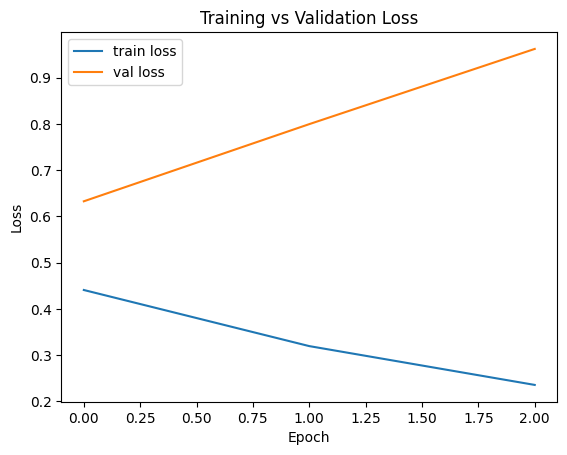

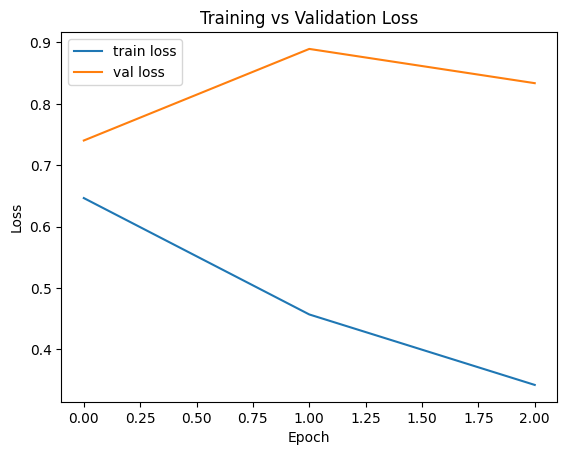

In [21]:
import matplotlib.pyplot as plt

def plot_train_val_loss(history):
    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.show()


plot_train_val_loss(history_rnn_1)
plot_train_val_loss(history_rnn_2)
plot_train_val_loss(history_rnn_3)

The training and validation curves diverge very early (around 0.2–0.3 epoch), indicating that the model begins to overfit almost immediately.
This is expected given the small dataset size and the subtle nature of implicit hate.
Therefore, we rely on early stopping rather than manually tuning the epoch count, as training for a full epoch already exceeds the optimal point.

BiLSTM (Implicit vs Not Hate) Report(without class weight):
              precision    recall  f1-score   support

           0     0.7429    0.8880    0.8090      1991
           1     0.6696    0.4248    0.5198      1064

    accuracy                         0.7267      3055
   macro avg     0.7062    0.6564    0.6644      3055
weighted avg     0.7174    0.7267    0.7083      3055



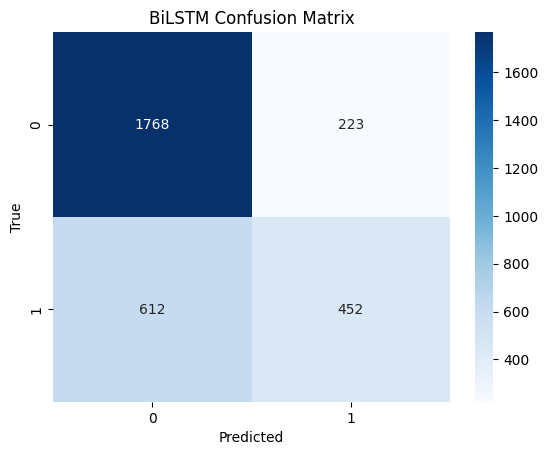

In [22]:
print("BiLSTM (Implicit vs Not Hate) Report(without class weight):")
print(classification_report(y_test, y_pred_1, digits=4))

cm_imp = confusion_matrix(y_test, y_pred_1)
sns.heatmap(cm_imp, annot=True, fmt="d", cmap="Blues")
plt.title("BiLSTM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

BiLSTM (Implicit vs Not Hate) Report(with class weight):
              precision    recall  f1-score   support

           0     0.7807    0.7418    0.7608      1991
           1     0.5580    0.6100    0.5828      1064

    accuracy                         0.6959      3055
   macro avg     0.6693    0.6759    0.6718      3055
weighted avg     0.7031    0.6959    0.6988      3055



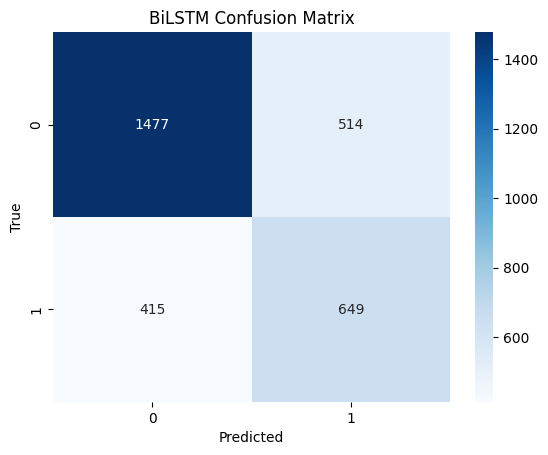

In [23]:
print("BiLSTM (Implicit vs Not Hate) Report(with class weight):")
print(classification_report(y_test, y_pred_2, digits=4))

cm_imp = confusion_matrix(y_test, y_pred_2)
sns.heatmap(cm_imp, annot=True, fmt="d", cmap="Blues")
plt.title("BiLSTM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

BiLSTM (Implicit vs Not Hate) Report(downsampling):
              precision    recall  f1-score   support

           0     0.7787    0.7529    0.7656      1991
           1     0.5646    0.5996    0.5816      1064

    accuracy                         0.6995      3055
   macro avg     0.6717    0.6763    0.6736      3055
weighted avg     0.7041    0.6995    0.7015      3055



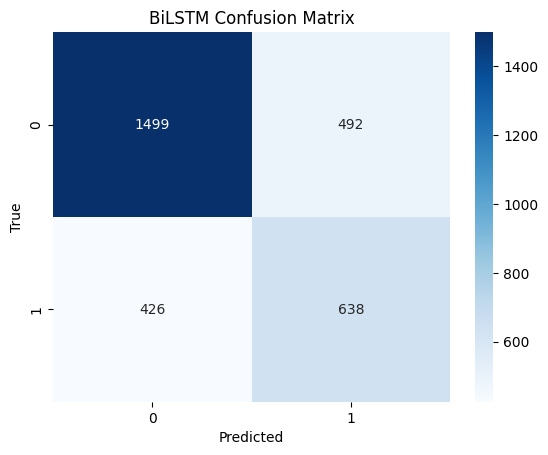

In [24]:
print("BiLSTM (Implicit vs Not Hate) Report(downsampling):")
print(classification_report(y_test, y_pred_3, digits=4))

cm_imp = confusion_matrix(y_test, y_pred_3)
sns.heatmap(cm_imp, annot=True, fmt="d", cmap="Blues")
plt.title("BiLSTM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Applying class weights improves the model’s ability to detect implicit hate — the minority class — by substantially increasing recall (from 0.46 to 0.64) and improving the F1 score for class 1. This indicates that the baseline model was strongly biased toward the majority “other” class, and class weighting helps correct this imbalance by encouraging the network to pay more attention to subtle hateful content.

The overall accuracy drops slightly, which is expected: increasing sensitivity to minority samples comes at the cost of misclassifying more majority-class examples. However, for this task, detecting implicit hate is more important than optimizing global accuracy.

In summary, class weighting provides a meaningful but limited improvement — a step in the right direction, but insufficient on its own. The task remains challenging, and more advanced models (e.g., BERT) are likely required to capture deeper contextual cues.

Possible Reasons:

1. Implicit hate rarely contains explicit lexical cues
2. RNNs struggle with long-range or abstract semantic dependencies
3. Data imbalance amplifies RNN weaknesses
4. Vocabulary-based sequence models cannot detect paraphrasing or contextual shifts
5. Overfitting occurs easily due to small dataset + high model capacity

**Downsample and class_wight produce similar results for LSTM.**

# Model 3: BERT

## Setup

In [25]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np


In [26]:
model_name = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2  # Implicit vs Not Hate
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model.to(device)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## Data Preparation

In [27]:
class HateDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = list(texts)
        self.labels = list(labels)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text  = str(self.texts[idx])
        label = int(self.labels[idx])

        enc = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )

        item = {
            "input_ids": enc["input_ids"].squeeze(0),       # (seq_len)
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long)
        }
        return item


In [28]:
MAX_LEN = 128
BATCH_SIZE = 16

train_dataset = HateDataset(X_train, y_train, tokenizer, max_len=MAX_LEN)
test_dataset  = HateDataset(X_test,  y_test,  tokenizer, max_len=MAX_LEN)
val_dataset  = HateDataset(X_val,  y_val,  tokenizer, max_len=MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)
val_loader  = DataLoader(val_dataset,  batch_size=BATCH_SIZE, shuffle=False)


In [29]:
train_bal_dataset = HateDataset(X_train_bal, y_train_bal, tokenizer, max_len=MAX_LEN)

train_bal_loader = DataLoader(train_bal_dataset, batch_size=BATCH_SIZE, shuffle=True)

### Model Training

### Original Dataset

In [30]:
num_epochs = 10
optimizer = AdamW(model.parameters(), lr=2e-5)
patience = 2
min_delta = 0.0

best_val_loss = float("inf")
best_state_dict = None

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    model.train()
    total_train_loss = 0.0

    for batch in train_loader:
        input_ids      = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels         = batch["labels"].to(device)

        optimizer.zero_grad()

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    print(f"Train loss: {avg_train_loss:.4f}")

    model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch in val_loader:
            input_ids      = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels         = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    print(f"Val loss:   {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss - min_delta:
        best_val_loss = avg_val_loss
        best_state_dict = model.state_dict()
        epochs_no_improve = 0
        print(">>> New best model saved.")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s).")

        if epochs_no_improve >= patience:
            print(f"*** Early stopping triggered at epoch {epoch+1}. ***")
            break

if best_state_dict is not None:
    model.load_state_dict(best_state_dict)
    print(f"\nLoaded best model with val loss = {best_val_loss:.4f}")
else:
    print("\nWarning: best_state_dict is None, something might be wrong.")


Epoch 1/10
Train loss: 0.5499
Val loss:   0.5152
>>> New best model saved.
Epoch 2/10
Train loss: 0.4336
Val loss:   0.5098
>>> New best model saved.
Epoch 3/10
Train loss: 0.3008
Val loss:   0.5954
No improvement for 1 epoch(s).
Epoch 4/10
Train loss: 0.1926
Val loss:   0.8736
No improvement for 2 epoch(s).
*** Early stopping triggered at epoch 4. ***

Loaded best model with val loss = 0.5098


In [31]:
import torch.nn.functional as F
model.eval()
all_preds = []
all_labels = []
all_probs  = []

with torch.no_grad():
    for batch in test_loader:
        input_ids      = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels         = batch["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        logits = outputs.logits
        probs = F.softmax(logits, dim=1)[:, 1]
        preds = torch.argmax(logits, dim=1)

        all_probs.append(probs.cpu().numpy())
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

y_test   = np.concatenate(all_labels)
y_pred_bert_1   = np.concatenate(all_preds)
y_prob_bert_1 = np.concatenate(all_probs)

print("BERT (Implicit vs Not Hate) Report:")
print(classification_report(y_test, y_pred_1, digits=4))

cm_bert_1 = confusion_matrix(y_test, y_pred_1)
print("Confusion Matrix:\n", cm_bert_1)


BERT (Implicit vs Not Hate) Report:
              precision    recall  f1-score   support

           0     0.7429    0.8880    0.8090      1991
           1     0.6696    0.4248    0.5198      1064

    accuracy                         0.7267      3055
   macro avg     0.7062    0.6564    0.6644      3055
weighted avg     0.7174    0.7267    0.7083      3055

Confusion Matrix:
 [[1768  223]
 [ 612  452]]


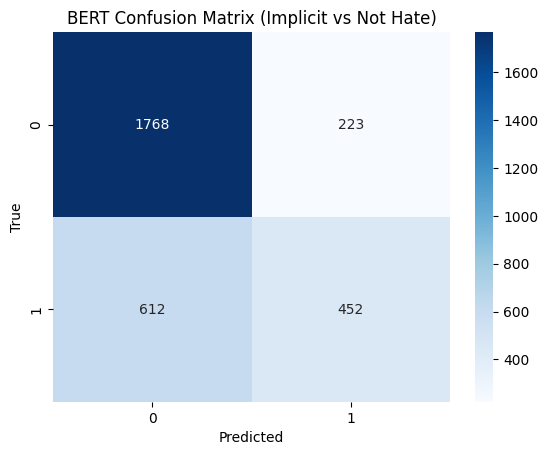

In [32]:
sns.heatmap(cm_bert_1, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("BERT Confusion Matrix (Implicit vs Not Hate)")
plt.show()


### with class weight

In [33]:
class_weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.array([0,1]),
    y=y_train
)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

In [34]:
num_epochs = 10
optimizer = AdamW(model.parameters(), lr=2e-5)

loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

best_val_loss = float("inf")
best_state_dict = None

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    model.train()
    total_train_loss = 0.0

    for batch in train_loader:
        optimizer.zero_grad()

        input_ids      = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels         = batch["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        logits = outputs.logits
        loss = loss_fct(logits, labels)

        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    print("Train loss:", total_train_loss / len(train_bal_loader))

    model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch in val_loader:
            input_ids      = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels         = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            logits = outputs.logits
            loss = loss_fct(logits, labels)

            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    print("Val loss:", avg_val_loss)

    if avg_val_loss < best_val_loss - min_delta:
        best_val_loss = avg_val_loss
        best_state_dict = model.state_dict()
        epochs_no_improve = 0
        print(">>> New best model saved.")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s).")

        if epochs_no_improve >= patience:
            print(f"*** Early stopping triggered at epoch {epoch+1}. ***")
            break

if best_state_dict is not None:
    model.load_state_dict(best_state_dict)
    print(f"\nLoaded best model with val loss = {best_val_loss:.4f}")
else:
    print("\nWarning: best_state_dict is None, something might be wrong.")


Epoch 1/10
Train loss: 0.17681677455353548
Val loss: 1.0421455692870454
>>> New best model saved.
Epoch 2/10
Train loss: 0.12666738271721492
Val loss: 1.2170431141141822
No improvement for 1 epoch(s).
Epoch 3/10
Train loss: 0.092717133868245
Val loss: 1.2345785017647044
No improvement for 2 epoch(s).
*** Early stopping triggered at epoch 3. ***

Loaded best model with val loss = 1.0421


In [35]:
import torch.nn.functional as F
model.eval()
all_preds = []
all_labels = []
all_probs  = []

with torch.no_grad():
    for batch in test_loader:
        input_ids      = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels         = batch["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        logits = outputs.logits
        probs = F.softmax(logits, dim=1)[:, 1]
        preds = torch.argmax(logits, dim=1)

        all_probs.append(probs.cpu().numpy())
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

y_test   = np.concatenate(all_labels)
y_pred_bert_2   = np.concatenate(all_preds)
y_prob_bert_2 = np.concatenate(all_probs)

print("BERT (Implicit vs Not Hate) Report(with class weight):")
print(classification_report(y_test, y_pred_bert_2, digits=4))

cm_bert_2 = confusion_matrix(y_test, y_pred_bert_2)
print("Confusion Matrix:\n", cm_bert_2)

BERT (Implicit vs Not Hate) Report(with class weight):
              precision    recall  f1-score   support

           0     0.7847    0.8202    0.8021      1991
           1     0.6324    0.5789    0.6045      1064

    accuracy                         0.7362      3055
   macro avg     0.7086    0.6996    0.7033      3055
weighted avg     0.7317    0.7362    0.7333      3055

Confusion Matrix:
 [[1633  358]
 [ 448  616]]


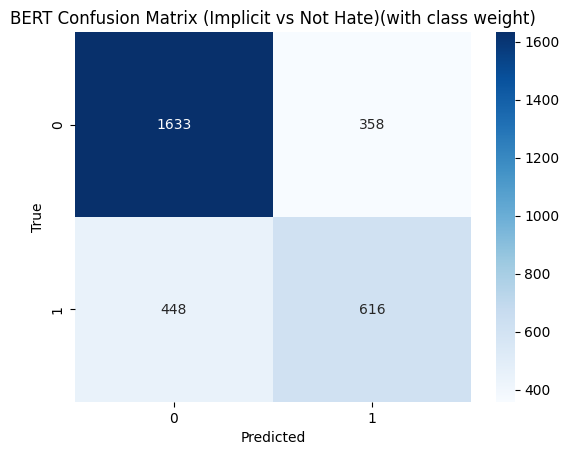

In [36]:
sns.heatmap(cm_bert_2, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("BERT Confusion Matrix (Implicit vs Not Hate)(with class weight)")
plt.show()

### Downsampling

In [37]:
num_epochs = 10
optimizer = AdamW(model.parameters(), lr=2e-5)

best_val_loss = float("inf")
best_state_dict = None

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    model.train()
    total_train_loss = 0.0

    for batch in train_bal_loader:
        input_ids      = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels         = batch["labels"].to(device)

        optimizer.zero_grad()

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    print(f"Train loss: {avg_train_loss:.4f}")

    model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch in val_loader:
            input_ids      = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels         = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    print(f"Val loss:   {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss - min_delta:
        best_val_loss = avg_val_loss
        best_state_dict = model.state_dict()
        epochs_no_improve = 0
        print(">>> New best model saved.")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s).")

        if epochs_no_improve >= patience:
            print(f"*** Early stopping triggered at epoch {epoch+1}. ***")
            break

if best_state_dict is not None:
    model.load_state_dict(best_state_dict)
    print(f"\nLoaded best model with val loss = {best_val_loss:.4f}")
else:
    print("\nWarning: best_state_dict is None, something might be wrong.")


Epoch 1/10
Train loss: 0.0386
Val loss:   1.1360
>>> New best model saved.
Epoch 2/10
Train loss: 0.0301
Val loss:   1.4145
No improvement for 1 epoch(s).
Epoch 3/10
Train loss: 0.0239
Val loss:   1.4577
No improvement for 2 epoch(s).
*** Early stopping triggered at epoch 3. ***

Loaded best model with val loss = 1.1360


In [38]:
import torch.nn.functional as F
model.eval()
all_preds = []
all_labels = []
all_probs  = []

with torch.no_grad():
    for batch in test_loader:
        input_ids      = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels         = batch["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        logits = outputs.logits
        probs = F.softmax(logits, dim=1)[:, 1]
        preds = torch.argmax(logits, dim=1)

        all_probs.append(probs.cpu().numpy())
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

y_test   = np.concatenate(all_labels)
y_pred_bert_3   = np.concatenate(all_preds)
y_prob_bert_3 = np.concatenate(all_probs)

print("BERT (Implicit vs Not Hate) Report(downsampling):")
print(classification_report(y_test, y_pred_bert_3, digits=4))

cm_bert_3 = confusion_matrix(y_test, y_pred_bert_3)
print("Confusion Matrix:\n", cm_bert_3)

BERT (Implicit vs Not Hate) Report(downsampling):
              precision    recall  f1-score   support

           0     0.7867    0.8056    0.7960      1991
           1     0.6191    0.5912    0.6048      1064

    accuracy                         0.7309      3055
   macro avg     0.7029    0.6984    0.7004      3055
weighted avg     0.7283    0.7309    0.7294      3055

Confusion Matrix:
 [[1604  387]
 [ 435  629]]


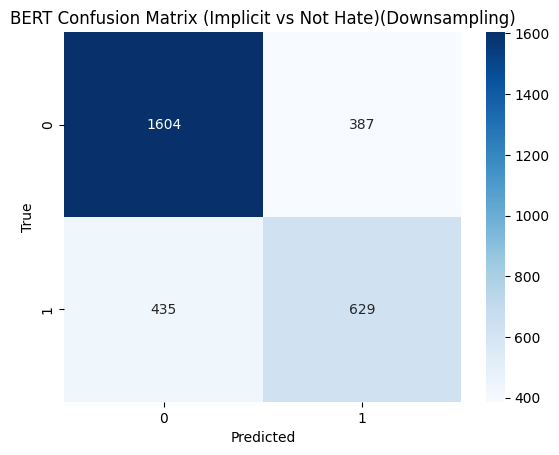

In [39]:
sns.heatmap(cm_bert_3, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("BERT Confusion Matrix (Implicit vs Not Hate)(Downsampling)")
plt.show()

# Final Evaluation

## Original Dataset

### ROC Curve

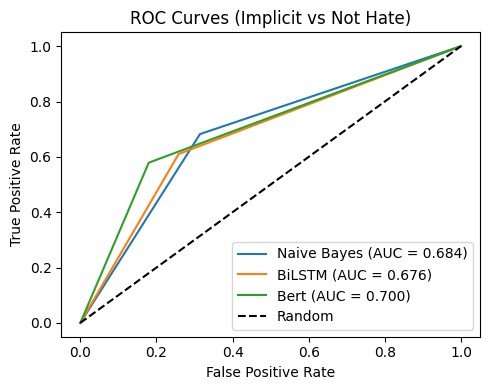

In [40]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curves(y_true, prob_dict):
    """
    """
    plt.figure(figsize=(5, 4))
    for name, y_pred in prob_dict.items():
        fpr, tpr, _ = roc_curve(y_true, y_pred, pos_label=1)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")

    plt.plot([0, 1], [0, 1], "k--", label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (Implicit vs Not Hate)")
    plt.legend()
    plt.tight_layout()
    plt.show()

pred_dict = {
    "Naive Bayes": y_pred_nb_2,
    "BiLSTM": y_pred_2,
    "Bert": y_pred_bert_2,
}
plot_roc_curves(y_test, pred_dict)

### PR Curve

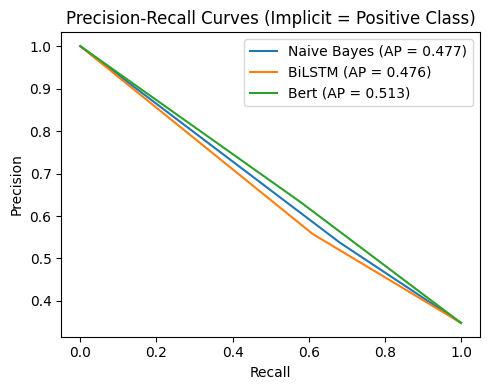

In [41]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_pr_curves(y_true, pred_dict):
    plt.figure(figsize=(5, 4))
    for name, y_pred in pred_dict.items():
        precision, recall, _ = precision_recall_curve(y_true, y_pred, pos_label=1)
        ap = average_precision_score(y_true, y_pred)
        plt.plot(recall, precision, label=f"{name} (AP = {ap:.3f})")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curves (Implicit = Positive Class)")
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_pr_curves(y_test, pred_dict)

### Error Example

In [42]:
test_df = pd.DataFrame({
    "text": X_test,
    "label": y_test,
})

def get_error_examples(df, y_true, y_pred, text_col="text"):
    df = df.copy()
    df["y_true"] = y_true
    df["y_pred"] = y_pred

    # False Negatives
    fn = df[(df["y_true"] == 1) & (df["y_pred"] == 0)]

    # False Positives
    fp = df[(df["y_true"] == 0) & (df["y_pred"] == 1)]

    return fn, fp

fn_nb, fp_nb       = get_error_examples(test_df, y_test, y_pred_nb_2)
fn_rnn, fp_rnn     = get_error_examples(test_df, y_test, y_pred_2)
fn_bert, fp_bert     = get_error_examples(test_df, y_test, y_pred_bert_2)



In [43]:
def show_examples(df, n=5, title="Examples"):
    print(f"\n===== {title} (n={min(n, len(df))}) =====")
    for i, row in df.sample(min(n, len(df)), random_state=42).iterrows():
        print(f"[true={row['y_true']}, pred={row['y_pred']}]")
        print(row["text"])
        print("-" * 50)

show_examples(fn_bert, n=5, title="BERT False Negatives")
show_examples(fp_bert, n=5, title="BERT False Positives")

show_examples(fn_nb,  n=3, title="NB False Negatives")
show_examples(fp_nb,  n=3, title="NB False Positives")

show_examples(fn_rnn, n=3, title="BiLSTM False Negatives")
show_examples(fp_rnn, n=3, title="BiLSTM False Positives")



===== BERT False Negatives (n=5) =====
[true=1, pred=0]
white people synagogues
--------------------------------------------------
[true=1, pred=0]
form pagan clubs can't deny clubs based religion nonwhites can't european pagans
--------------------------------------------------
[true=1, pred=0]
white supremacist
--------------------------------------------------
[true=1, pred=0]
anti white racist attacks obama's america video
--------------------------------------------------
[true=1, pred=0]
scandinavians clearly spanish white peoples
--------------------------------------------------

===== BERT False Positives (n=5) =====
[true=0, pred=1]
wow kkk alive white brother hood unite ku klux klan
--------------------------------------------------
[true=0, pred=1]
jews sob pro hitler fb post african national congress social media manager
--------------------------------------------------
[true=0, pred=1]
black money holders que thank ji
--------------------------------------------------
[

On the original, highly imbalanced data, even BERT struggles to capture implicit hate reliably.
When we rebalance the training set via undersampling, BERT’s recall on implicit hate increases substantially, but this comes at the cost of more false positives and reduced exposure to the full diversity of non-hate language.